## Autoregressive Integrated Moving Average

ARIMA

- Autoregressive - AR(p)
- Integrated - I(d)
- Moving Average - MA(q)

---
- Non-seasonial ARIMA : ARIMA(p,d,q)
- Seasonal ARIMA : ARIMA(p,d,q)(P,D,Q)m

### Stationary

- 연속되는 숫자들의 평균(mean)이 변하지않음 (time invariant)
- 연속되는 숫자들의 분산(variance)이 변하지않음 (time invariant)
- 연속되는 숫자들의 공분산(covariance)이 변하지않음 (time invariant)
---
non-stationary 한 경우, differencing 을 통하여 stationary 하게 변환시킴

#### Stationary Test

- Augmented Dickey-Fuller test

통계적 시험을 통해 시계열 데이터가 stationary 특성을 보이는지 확인

#### Differencing

- stationary 할 때까지 differencing 반복
- seasonal 데이터일 경우, season을 기준으로 differencing 시행

ex) 1년 주기를 갖는 seasonal 데이터를 월간을 기준으로 differencing 할 경우, 1이 아닌 12로 differencing 시행

#### Identification of ARIMA

- AutoCorrelation Plot (a.k.a Coreelogram)

특정 시간만큼 지연된(lag) 시점의 데이터와의 연관성을 보여준다.

- Partial AutoCorrelation Plot

t 시점과 특정 시간만큼 지연된(lag) 시점 t-p 의 연관성을 그 사이(t..t-p) 데이터의 영향을 배제하고 보여준다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import statsmodels.api as sm

In [4]:
df=pd.read_csv('./data/monthly-milk-production.csv',
           index_col='Month',parse_dates=True)

In [5]:
df.head()

,pounds per cow
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   pounds per cow  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


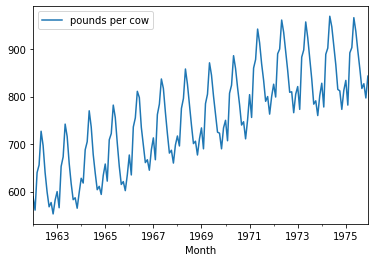

In [7]:
df.plot()

In [8]:
ppc=df['pounds per cow']

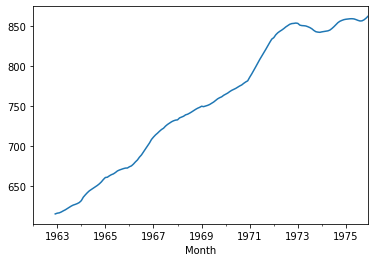

In [10]:
ppc.rolling(12).mean().plot() # 1년의 mv

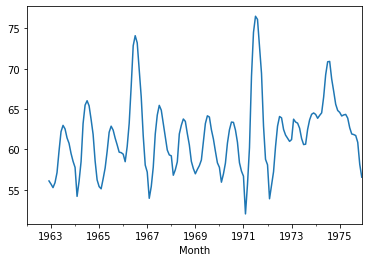

In [11]:
ppc.rolling(12).std().plot()

분산=표준편차^2 이므로, 표준편차를 확인한 결과 time invariant 함을 볼 수 있다.

이는, non-stationary 한 시계열 특성임을 알려준다.

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [13]:
decomposition=seasonal_decompose(df['pounds per cow'])

<Figure size 1080x504 with 0 Axes>

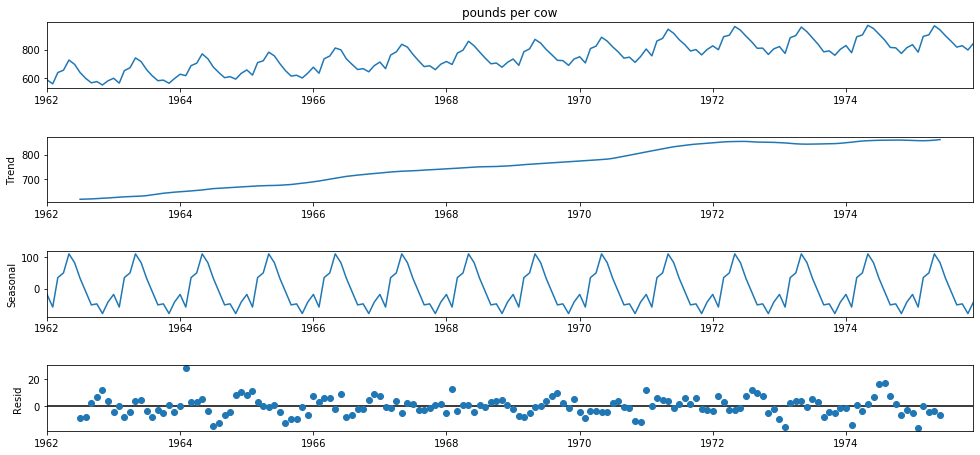

In [14]:
fig=plt.figure(figsize=(15,7))
fig=decomposition.plot()
fig.set_size_inches(15,7)

Residual 을 다루어서, 시계열 모델을 만든다.

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
result=adfuller(df['pounds per cow'])

In [17]:
result

(-1.3038115874221246,
 0.627426708603034,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

In [23]:
# result dict의 2번째 값이 p-value 이다.

def adf_check(ts):
    result=adfuller(ts)
    
    if result[1]<=0.05 :
        print('Stationary {}'.format(result[1]))
    else:
        print('Non-Stationary {}'.format(result[1]))

In [24]:
adf_check(df['pounds per cow'])

Non-Stationary 0.627426708603034


In [25]:
df['1st diff']=df['pounds per cow'] - df['pounds per cow'].shift(1)

In [26]:
df.head()

,pounds per cow,1st diff
Month,,
1962-01-01,589,NaN
1962-02-01,561,-28.0
1962-03-01,640,79.0
1962-04-01,656,16.0
1962-05-01,727,71.0


In [28]:
adf_check(df['1st diff'].dropna())

Stationary 0.03006800400178688


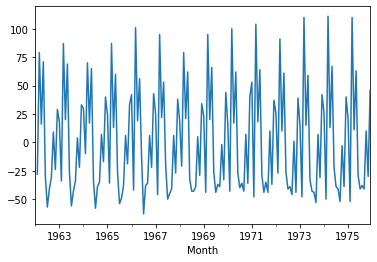

In [29]:
df['1st diff'].plot()

In [30]:
df['2nd diff']=df['1st diff'] - df['1st diff'].shift(1)

In [31]:
df.head()

,pounds per cow,1st diff,2nd diff
Month,,,
1962-01-01,589,NaN,NaN
1962-02-01,561,-28.0,NaN
1962-03-01,640,79.0,107.0
1962-04-01,656,16.0,-63.0
1962-05-01,727,71.0,55.0


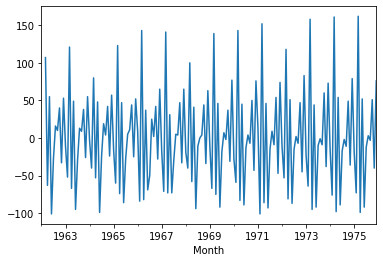

In [32]:
df['2nd diff'].plot()

In [33]:
adf_check(df['2nd diff'].dropna())

Stationary 1.1126989332083069e-26


In [34]:
df['seasonal diff']=df['pounds per cow'] - df['pounds per cow'].shift(12)

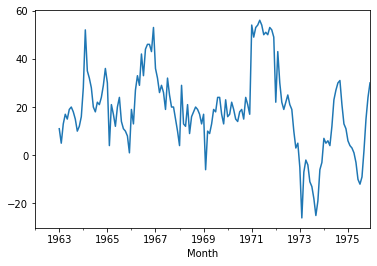

In [35]:
df['seasonal diff'].plot()

In [36]:
adf_check(df['seasonal diff'].dropna())

Non-Stationary 0.16079880527711304


In [37]:
df['seasonal 1st diff']=df['1st diff']-df['1st diff'].shift(12)

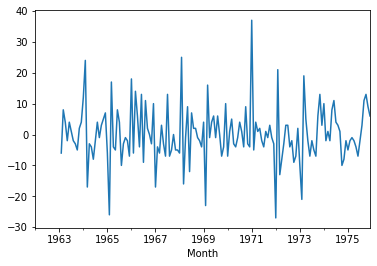

In [38]:
df['seasonal 1st diff'].plot()

In [39]:
adf_check(df['seasonal 1st diff'].dropna())

Stationary 1.86542343187882e-05


#### 차분

- differencing : d=1
- seasonal differencing : D=1

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

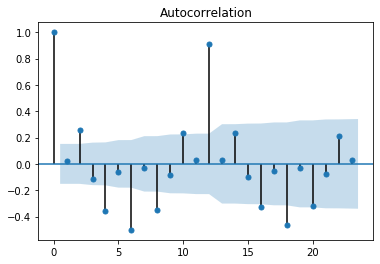

In [43]:
plot_acf(df['1st diff'].dropna());

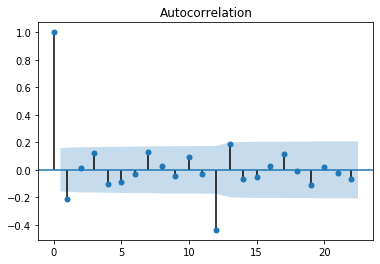

In [45]:
plot_acf(df['seasonal 1st diff'].dropna());

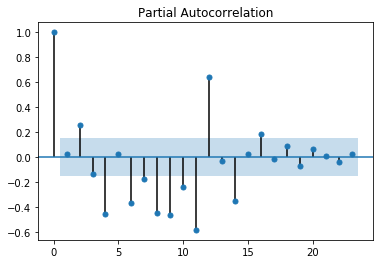

In [50]:
plot_pacf(df['1st diff'].dropna(), method='ywm');

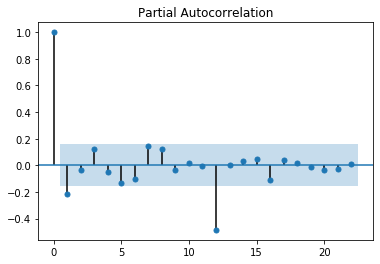

In [48]:
plot_pacf(df['seasonal 1st diff'].dropna());

Thus,

- p=0, d=1, q=0
- P=1, D=1, Q=1

In [52]:
model=sm.tsa.statespace.SARIMAX(df['pounds per cow'],
                               order=(0,1,0),
                               seasonal_order=(1,1,1,12))

C:\Users\river\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\river\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [53]:
result=model.fit()

In [54]:
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                       pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -534.065
Date:                              Sun, 31 Jan 2021   AIC                           1074.131
Time:                                      00:44:36   BIC                           1083.261
Sample:                                  01-01-1962   HQIC                          1077.839
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.58

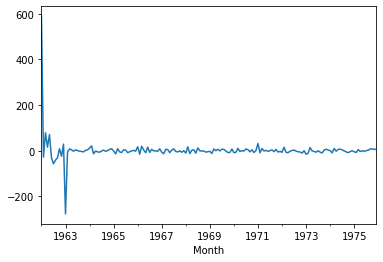

In [56]:
result.resid.plot()

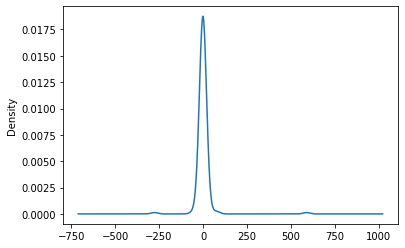

In [57]:
result.resid.plot(kind='kde')

In [58]:
len(df['pounds per cow'])

168

In [59]:
df['forecast']=result.predict(start=150, end=168, dynamic=True)

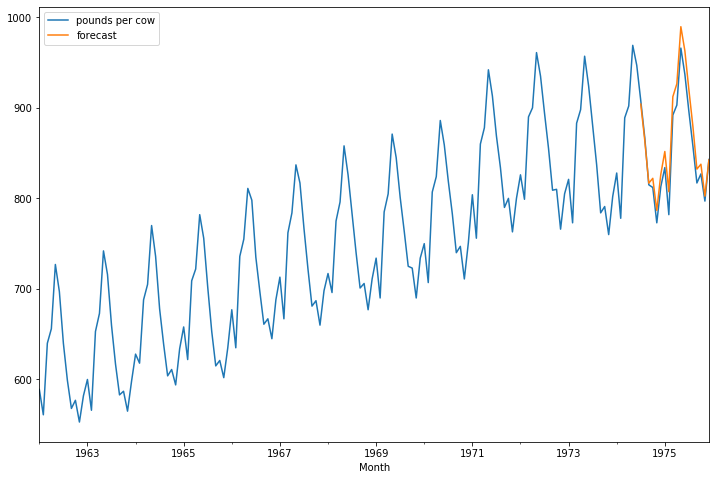

In [60]:
df[['pounds per cow','forecast']].plot(figsize=(12,8))